# Informações

Nome: Francisco Altanizio Batista de Castro Junior

Matrícula: 575220

Curso: ENGENHARIA DE TRANSPORTES

Disciplina: CKP8277 - APRENDIZAGEM AUTOMÁTICA

# Classes e funções para as questões 1 e 2

In [1]:
import numpy as np  # para operações
import matplotlib.pyplot as plt  # para plotagem
import seaborn as sns  # para plotagem
import pandas as pd  # para algumas poucas manipulações

In [2]:
def calc_acuracia_global(y, y_hat):
    """
    Calcular a acurácia global
    """
    return np.mean(y == y_hat)


def calc_acuracia_classe(y, y_hat):
    """
    Calcular a acurácia por classe
    """
    classes = np.unique(y)
    acuracia_por_classe = {}

    for classe in classes:
        idx_classe = y == classe
        acuracia = np.mean(y_hat[idx_classe] == y[idx_classe])
        acuracia_por_classe[int(classe)] = acuracia

    return acuracia_por_classe


def matriz_confusao(y, y_hat):
    """
    Calcular a matriz de confusão
    """
    classes = np.unique(y)
    n_classes = len(classes)
    matriz = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            matriz[i, j] = np.sum((y == true_class) & (y_hat == pred_class))
    return matriz

In [3]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self, X):
        return X * self.std + self.mean

In [4]:
class CrossValidation:
    """
    Classe para fazer cross-validation
    kfold - número de folds
    seed - setar uma seed para não ser aleatório
    standard - padronizar variáveis usando dados de treino como base
    """

    def __init__(self, modelo, kfold=10, seed=None, standard=True):
        self.modelo = modelo
        self.kfold = kfold
        self.seed = seed
        self.acuracia = []
        self.acuracia_classe = []
        self.standard = standard

    def fit(self, X, y):
        self.acuracia = []
        self.acuracia_classe = []
        random_generator = np.random.default_rng(seed=self.seed)
        size_sample = int(len(X) / self.kfold)
        indexes = np.arange(len(X))
        random_generator.shuffle(indexes)
        
        for i in range(self.kfold):
            test_indexes = indexes[i * size_sample : (i + 1) * size_sample]
            train_indexes = np.concatenate(
                (indexes[: i * size_sample], indexes[(i + 1) * size_sample :])
            )
            
            fit_model = self.modelo()

            print(f"k = {i + 1}/{self.kfold}")
            
            if self.standard:
                X_std = StandardScaler()
                X_train = X_std.fit_transform(X[train_indexes])
                X_test = X_std.transform(X[test_indexes])
            else:
                X_train = X[train_indexes]
                X_test = X[test_indexes]

            fit_model.fit(X_train, y[train_indexes])
            
            y_test_hat = fit_model.predict(X_test).ravel()
            acuracia = calc_acuracia_global(y[test_indexes].ravel(), y_test_hat)
            acuracia_classe = calc_acuracia_classe(y[test_indexes].ravel(), y_test_hat)
            matriz_conf = matriz_confusao(y[test_indexes].ravel(), y_test_hat)

            print("Matriz de confusão:")
            print(matriz_conf)
            print(f"Acurácia: {acuracia}")
            print(f"Acurácia classe: {acuracia_classe}")

            print(
                "------------------------------------------------------------------------------------------------------"
            )

            self.acuracia.append(acuracia)
            self.acuracia_classe.append(acuracia_classe)

        self.acuracia_classe = {
            classe: [k[classe] for k in self.acuracia_classe]
            for classe in self.acuracia_classe[0]
        }

    def summary(self):
        print("------------------------------------------------------------")
        print(self.modelo.__doc__.strip())
        print("------------------------------------------------------------")
        print(
            f"Acurácia - Média: {np.mean(self.acuracia):0.3f} | DP: {np.std(self.acuracia, ddof=1):0.3f}"
        )
        print("Acurácia por classe:")
        classes_media = {
            classe: np.mean(value) for classe, value in self.acuracia_classe.items()
        }
        classes_dp = {
            classe: np.std(value, ddof=1)
            for classe, value in self.acuracia_classe.items()
        }
        for classe in classes_media.keys():
            print(
                f"   - {classe} - Média: {classes_media[classe]:0.3f} | DP: {classes_dp[classe]:0.3f}"
            )
        print("------------------------------------------------------------")

In [5]:
class LogitBinario:
    """
    Modelo Logit Binário - Algorítmo GD
    """

    def __init__(self):
        self.w = None
        self.erro = None
        self.cross_entropy_loss = []

    def _logit(self, z):
        return 1 / (1 + np.exp(-z))

    def _add_constant(self, X):
        ones_vetor = np.ones(X.shape[0])
        ones_vetor = ones_vetor.reshape(-1, 1)
        return np.concatenate([ones_vetor, X], axis=1)

    def fit(self, X_train, y_train, alpha=0.02, epocas=1000):
        N = X_train.shape[0]
        X_train = self._add_constant(X_train)
        M = X_train.shape[1]

        self.w = np.zeros((M, 1))
        self.cross_entropy_loss = []
        for epoca in range(epocas):
            self.erro = y_train - self._logit(X_train @ self.w)
            self.w = self.w + (alpha / N) * (X_train.T @ self.erro)

            p = np.clip(self._logit(X_train @ self.w), 1e-10, 1 - 1e-10)
            cross_entropy_loss = -(
                1 / N * np.sum(y_train * np.log(p) + (1 - y_train) * np.log(1 - p))
            )

            self.cross_entropy_loss.append((epoca, cross_entropy_loss))

        self._plot_loss()

    def predict_prob(self, X):
        X = self._add_constant(X)
        return self._logit(X @ self.w)

    def predict(self, X):
        X = self._add_constant(X)
        return np.where(self._logit(X @ self.w) > 0.5, 1, 0)

    def _plot_loss(self):
        ep, er = zip(*self.cross_entropy_loss)
        plt.figure(figsize=(4, 2))
        plt.plot(ep, er)
        plt.xlabel("Épocas")
        plt.ylabel("Cross Entropy Loss")
        plt.title("Função custo")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [6]:
class ADG:
    """
    Modelo Análise de Discriminante Gaussiano
    """

    def __init__(self):
        self.parametros = None
        self.classes = None
        self.classes_prop = None

    def fit(self, X_train, y_train):
        self.classes, counts = np.unique(y_train, return_counts=True)
        self.classes_prop = {
            int(key): value for key, value in zip(self.classes, counts / np.sum(counts))
        }
        self.parametros = {}

        for classe in self.classes:
            idx_classe = y_train.ravel() == classe
            X_classe = X_train[idx_classe, :]
            X_classe_media = X_classe.mean(axis=0)
            X_classe_center = X_classe - X_classe_media
            X_classe_cov = (1 / (X_classe.shape[0] - 1)) * (
                X_classe_center.T @ X_classe_center
            )

            self.parametros[int(classe)] = {
                "media": X_classe_media,
                "cov": X_classe_cov,
            }

    def predict(self, X):
        y_hat = []
        for i in range(X.shape[0]):
            resultado = []
            for classe in self.classes:
                media = self.parametros[int(classe)]["media"]
                cov = self.parametros[int(classe)]["cov"]
                diff = X[i, :] - media
                out = (
                    np.log(self.classes_prop[int(classe)])
                    - (1 / 2) * np.log(np.linalg.det(cov))
                    - (1 / 2) * (diff.T @ np.linalg.inv(cov) @ diff)
                )
                resultado.append(out)
            y_hat.append(self.classes[np.argmax(resultado)])
        return np.array(y_hat).reshape(-1, 1)


In [7]:
class NaiveBayesGaussiano:
    """
    Modelo Naive Bayes Gaussiano
    """

    def __init__(self):
        self.parametros = None
        self.classes = None
        self.classes_prop = None

    def fit(self, X_train, y_train):
        self.classes, counts = np.unique(y_train, return_counts=True)
        self.classes_prop = {
            int(key): value for key, value in zip(self.classes, counts / np.sum(counts))
        }
        self.parametros = {}

        for classe in self.classes:
            idx_classe = y_train.ravel() == classe
            X_classe = X_train[idx_classe, :]
            X_classe_media = X_classe.mean(axis=0)
            X_classe_var = X_classe.var(axis=0, ddof=1)

            self.parametros[int(classe)] = {
                "media": X_classe_media,
                "var": X_classe_var,
            }

    def predict(self, X):
        y_hat = []
        for i in range(X.shape[0]):
            resultado = []
            for classe in self.classes:
                media = self.parametros[int(classe)]["media"]
                var = self.parametros[int(classe)]["var"]
                diff = X[i, :] - media
                out = (
                    np.log(self.classes_prop[int(classe)])
                    - (1 / 2) * np.sum(np.log(var * 2 * np.pi))
                    - (1 / 2) * np.sum((diff**2) / var)
                )
                resultado.append(out)
            y_hat.append(self.classes[np.argmax(resultado)])
        return np.array(y_hat).reshape(-1, 1)


# **Questão 1**  
Considere o conjunto de dados disponível em *breastcancer.csv*, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída.  

Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa.  

Maiores detalhes sobre os dados podem ser conferidos em:  
https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset



In [8]:
data = np.genfromtxt("breastcancer.csv", delimiter=",")

In [9]:
data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 4.601e-01, 1.189e-01,
        1.000e+00],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 2.750e-01, 8.902e-02,
        1.000e+00],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 3.613e-01, 8.758e-02,
        1.000e+00],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 2.218e-01, 7.820e-02,
        1.000e+00],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 4.087e-01, 1.240e-01,
        1.000e+00],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 2.871e-01, 7.039e-02,
        0.000e+00]], shape=(569, 31))

In [10]:
data.shape

(569, 31)

In [11]:
X = data[:, 0:30]

In [12]:
y = data[:, 30]

In [13]:
X.shape

(569, 30)

In [14]:
y = y.reshape(-1, 1)

In [15]:
y.shape

(569, 1)

In [16]:
# Só vendo as prop.
classes, counts = np.unique(y, return_counts=True)
{int(key): value for key, value in zip(classes, counts / np.sum(counts))}

{0: np.float64(0.6274165202108963), 1: np.float64(0.37258347978910367)}

## a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

– Regressão logística (treinado com GD ou SGD);  
– Análise do discriminante Gaussiano;  
– Naive Bayes Gaussiano



In [18]:
################################################################################################################
#LEMBRANDO: as classes dos modelos e a classe CrossValidation foram definidas nas primeiras células do notebook#
################################################################################################################

In [19]:
# Na classe LogitBinario, o intercepto já é inserido
# Na classe CrossValidation, os dados são padronizados se standard=True — utilizando-se as estatísticas apenas dos folds de treino
logit_cross_validation = CrossValidation(
    modelo=LogitBinario, kfold=10, seed=3, standard=True
)

k = 1/10


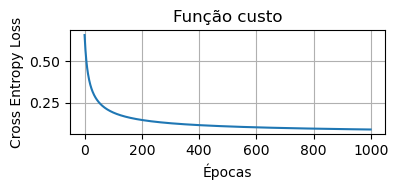

Matriz de confusão:
[[35  0]
 [ 0 21]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 2/10


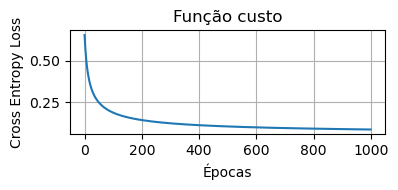

Matriz de confusão:
[[32  0]
 [ 0 24]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 3/10


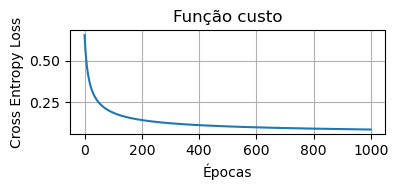

Matriz de confusão:
[[36  1]
 [ 1 18]]
Acurácia: 0.9642857142857143
Acurácia classe: {0: np.float64(0.972972972972973), 1: np.float64(0.9473684210526315)}
------------------------------------------------------------------------------------------------------
k = 4/10


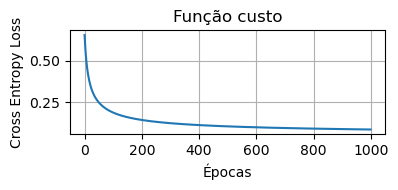

Matriz de confusão:
[[36  0]
 [ 0 20]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 5/10


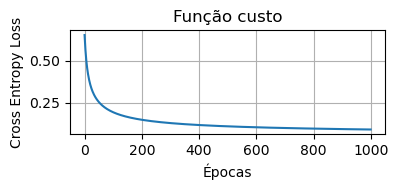

Matriz de confusão:
[[33  0]
 [ 0 23]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 6/10


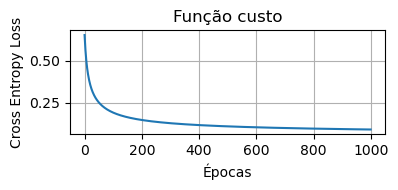

Matriz de confusão:
[[34  0]
 [ 0 22]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 7/10


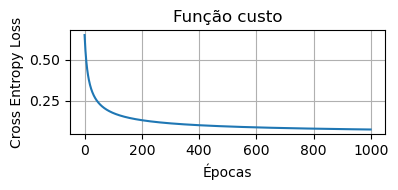

Matriz de confusão:
[[40  0]
 [ 5 11]]
Acurácia: 0.9107142857142857
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.6875)}
------------------------------------------------------------------------------------------------------
k = 8/10


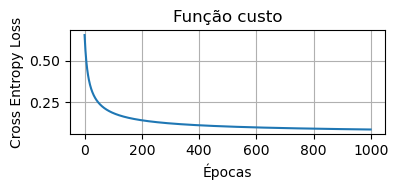

Matriz de confusão:
[[33  0]
 [ 0 23]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 9/10


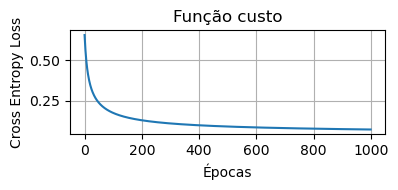

Matriz de confusão:
[[34  0]
 [ 3 19]]
Acurácia: 0.9464285714285714
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.8636363636363636)}
------------------------------------------------------------------------------------------------------
k = 10/10


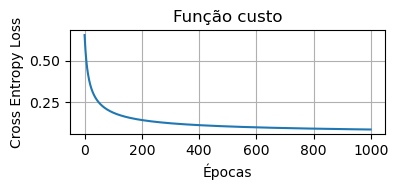

Matriz de confusão:
[[37  2]
 [ 0 17]]
Acurácia: 0.9642857142857143
Acurácia classe: {0: np.float64(0.9487179487179487), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------


In [20]:
logit_cross_validation.fit(X, y) 

In [21]:
# Na classe CrossValidation, os dados são padronizados se standard=True — utilizando-se as estatísticas apenas dos folds de treino
adg_cross_validation = CrossValidation(modelo=ADG, kfold=10, seed=3, standard=False)

In [22]:
adg_cross_validation.fit(X, y)

k = 1/10
Matriz de confusão:
[[34  1]
 [ 0 21]]
Acurácia: 0.9821428571428571
Acurácia classe: {0: np.float64(0.9714285714285714), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[31  1]
 [ 0 24]]
Acurácia: 0.9821428571428571
Acurácia classe: {0: np.float64(0.96875), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[37  0]
 [ 1 18]]
Acurácia: 0.9821428571428571
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.9473684210526315)}
------------------------------------------------------------------------------------------------------
k = 4/10
Matriz de confusão:
[[36  0]
 [ 0 20]]
Acurácia: 1.0
Acurácia classe: {0: np.float64(1.0), 1: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 5/10
Matriz de confusão:


In [23]:
naive_bayes_cross_validation = CrossValidation(modelo=NaiveBayesGaussiano, kfold=10, seed=3, standard=False)

In [24]:
naive_bayes_cross_validation.fit(X, y)

k = 1/10
Matriz de confusão:
[[35  0]
 [ 1 20]]
Acurácia: 0.9821428571428571
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.9523809523809523)}
------------------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[31  1]
 [ 2 22]]
Acurácia: 0.9464285714285714
Acurácia classe: {0: np.float64(0.96875), 1: np.float64(0.9166666666666666)}
------------------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[36  1]
 [ 3 16]]
Acurácia: 0.9285714285714286
Acurácia classe: {0: np.float64(0.972972972972973), 1: np.float64(0.8421052631578947)}
------------------------------------------------------------------------------------------------------
k = 4/10
Matriz de confusão:
[[36  0]
 [ 1 19]]
Acurácia: 0.9821428571428571
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.95)}
---------------------------------------------------------------------------------------

## b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

In [25]:
logit_cross_validation.summary()

------------------------------------------------------------
Modelo Logit Binário - Algorítmo GD
------------------------------------------------------------
Acurácia - Média: 0.979 | DP: 0.031
Acurácia por classe:
   - 0 - Média: 0.992 | DP: 0.017
   - 1 - Média: 0.950 | DP: 0.102
------------------------------------------------------------


In [26]:
adg_cross_validation.summary()

------------------------------------------------------------
Modelo Análise de Discriminante Gaussiano
------------------------------------------------------------
Acurácia - Média: 0.961 | DP: 0.038
Acurácia por classe:
   - 0 - Média: 0.965 | DP: 0.038
   - 1 - Média: 0.947 | DP: 0.082
------------------------------------------------------------


In [27]:
naive_bayes_cross_validation.summary()

------------------------------------------------------------
Modelo Naive Bayes Gaussiano
------------------------------------------------------------
Acurácia - Média: 0.939 | DP: 0.047
Acurácia por classe:
   - 0 - Média: 0.957 | DP: 0.043
   - 1 - Média: 0.904 | DP: 0.085
------------------------------------------------------------


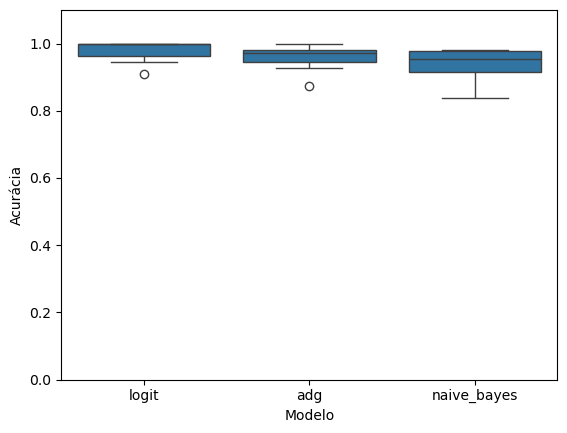

In [28]:
resultados_finais = pd.DataFrame(
    {
        "logit": logit_cross_validation.acuracia,
        "adg": adg_cross_validation.acuracia,
        "naive_bayes": naive_bayes_cross_validation.acuracia,
    }
)
resultados_finais = resultados_finais.melt(value_name="Acurácia", var_name="Modelo")
sns.boxplot(data=resultados_finais, y="Acurácia", x="Modelo")
plt.ylim(0, 1.1)
plt.show()

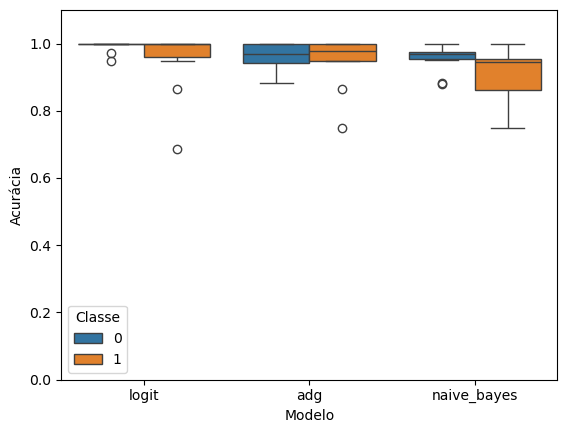

In [29]:
logit_data = pd.DataFrame(logit_cross_validation.acuracia_classe).assign(Modelo="logit")
adg_data = pd.DataFrame(adg_cross_validation.acuracia_classe).assign(Modelo="adg")
naive_bayes_data = pd.DataFrame(naive_bayes_cross_validation.acuracia_classe).assign(
    Modelo="naive_bayes"
)
resultados_finais = pd.concat([logit_data, adg_data, naive_bayes_data], axis=0)
resultados_finais = resultados_finais.melt(
    id_vars="Modelo", var_name="Classe", value_name="Acurácia"
)
sns.boxplot(data=resultados_finais, y="Acurácia", x="Modelo", hue="Classe")
plt.ylim(0, 1.1)
plt.show()

# **Questão 2**  
Considere o conjunto de dados disponível em *vehicle.csv*, organizado em 19 colunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída.  

Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (Hierarchical Image Processing System). A tarefa consiste em classificar o veículo em 4 classes (*bus*, *opel*, *saab* e *van*).  

Maiores detalhes sobre os dados podem ser conferidos em:  
https://www.openml.org/search?type=data&sort=runs&id=54


In [30]:
class LogitMultinomial:
    """
    Modelo Regressão Logística Multinomial - Algorítmo GD
    """

    def __init__(self):
        self.W = None
        self.erro = None
        self.cross_entropy_loss = []

    def _add_constant(self, X):
        ones_vetor = np.ones(X.shape[0])
        ones_vetor = ones_vetor.reshape(-1, 1)
        return np.concatenate([ones_vetor, X], axis=1)

    def _softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

    def fit(self, X_train, y_train, alpha=0.1, epocas=3000):
        X_train = self._add_constant(X_train)
        N = X_train.shape[0]
        M = X_train.shape[1]
        n_classes = np.unique(y_train).shape[0]

        y_one_hot = y_train.flatten().astype(int)
        y_one_hot = np.eye(n_classes)[y_one_hot]

        self.W = np.zeros((M, n_classes))
        self.cross_entropy_loss = []

        for epoca in range(epocas):
            self.erro = y_one_hot - self._softmax(X_train @ self.W)
            self.W = self.W + (alpha / N) * (X_train.T @ self.erro)

            probs = self._softmax(X_train @ self.W)

            cross_entropy_loss = -(1 / N) * np.sum(y_one_hot * np.log(probs + 1e-15))

            self.cross_entropy_loss.append((epoca, cross_entropy_loss))

        self._plot_loss()

    def predict_prob(self, X):
        X = self._add_constant(X)
        return self._softmax(X @ self.W)

    def predict(self, X):
        X = self._add_constant(X)
        return np.argmax(self._softmax(X @ self.W), axis=1)

    def _plot_loss(self):
        ep, er = zip(*self.cross_entropy_loss)
        plt.figure(figsize=(4, 2))
        plt.plot(ep, er)
        plt.xlabel("Épocas")
        plt.ylabel("Cross Entropy Loss")
        plt.title("Função custo")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [31]:
data = np.genfromtxt("vehicle.csv", delimiter=",")

In [32]:
data

array([[ 95.,  48.,  83., ..., 187., 197.,   3.],
       [ 91.,  41.,  84., ..., 189., 199.,   3.],
       [104.,  50., 106., ..., 188., 196.,   2.],
       ...,
       [106.,  54., 101., ..., 187., 201.,   2.],
       [ 86.,  36.,  78., ..., 190., 195.,   2.],
       [ 85.,  36.,  66., ..., 186., 190.,   3.]], shape=(846, 19))

In [33]:
data.shape

(846, 19)

In [34]:
X = data[:, 0:18]

In [35]:
y = data[:, 18]

In [36]:
X.shape

(846, 18)

In [37]:
y = y.reshape(-1, 1)

In [38]:
y.shape

(846, 1)

In [39]:
classes, counts = np.unique(y, return_counts=True)
{int(key): value for key, value in zip(classes, counts / np.sum(counts))}

{0: np.float64(0.2576832151300236),
 1: np.float64(0.25059101654846333),
 2: np.float64(0.2565011820330969),
 3: np.float64(0.23522458628841608)}

## a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação multiclasse nos dados em questão. Para tanto, use as abordagens abaixo:

– Regressão softmax (treinado com GD ou SGD);  
– Análise do discriminante Gaussiano;  
– Naive Bayes Gaussiano


In [40]:
#########################################################################################################
#LEMBRANDO: as classes dos modelos (com exceção do LogitMultinomia, que está no início da Questão 2) e a#
#classe CrossValidation foram definidas nas primeiras células do notebook                               #
#########################################################################################################

In [41]:
# Na classe LogitMultinomial, o intercepto já é inserido
# Na classe CrossValidation, os dados são padronizados se standard=True — utilizando-se as estatísticas apenas dos folds de treino
logit_multinomial_cross_validation = CrossValidation(modelo=LogitMultinomial, kfold=10, seed=3, standard=True)

k = 1/10


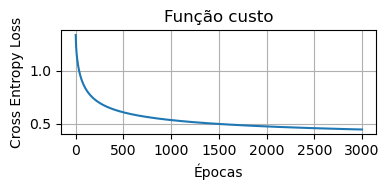

Matriz de confusão:
[[23  1  0  0]
 [ 1 12  9  2]
 [ 0  5 11  3]
 [ 0  0  0 17]]
Acurácia: 0.75
Acurácia classe: {0: np.float64(0.9583333333333334), 1: np.float64(0.5), 2: np.float64(0.5789473684210527), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 2/10


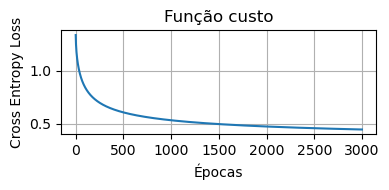

Matriz de confusão:
[[27  0  0  1]
 [ 1  9  4  2]
 [ 2  8 19  0]
 [ 1  0  0 10]]
Acurácia: 0.7738095238095238
Acurácia classe: {0: np.float64(0.9642857142857143), 1: np.float64(0.5625), 2: np.float64(0.6551724137931034), 3: np.float64(0.9090909090909091)}
------------------------------------------------------------------------------------------------------
k = 3/10


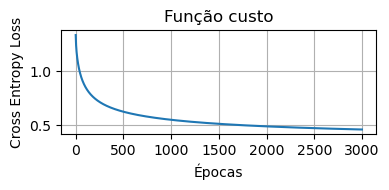

Matriz de confusão:
[[23  0  0  0]
 [ 0  9  4  0]
 [ 0  7 13  1]
 [ 0  0  0 27]]
Acurácia: 0.8571428571428571
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.6923076923076923), 2: np.float64(0.6190476190476191), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 4/10


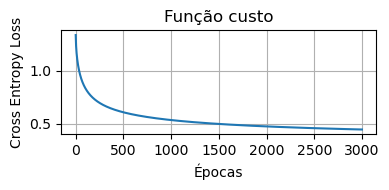

Matriz de confusão:
[[20  2  0  1]
 [ 1 18  9  0]
 [ 0  5 11  1]
 [ 1  1  0 14]]
Acurácia: 0.75
Acurácia classe: {0: np.float64(0.8695652173913043), 1: np.float64(0.6428571428571429), 2: np.float64(0.6470588235294118), 3: np.float64(0.875)}
------------------------------------------------------------------------------------------------------
k = 5/10


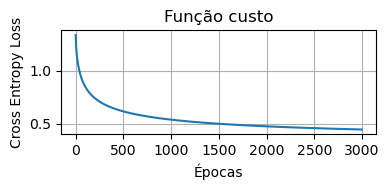

Matriz de confusão:
[[20  0  0  0]
 [ 2  9  8  0]
 [ 1  7 16  0]
 [ 1  0  0 20]]
Acurácia: 0.7738095238095238
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.47368421052631576), 2: np.float64(0.6666666666666666), 3: np.float64(0.9523809523809523)}
------------------------------------------------------------------------------------------------------
k = 6/10


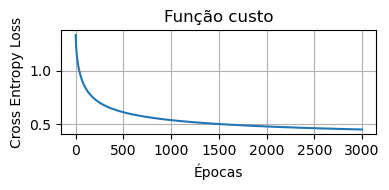

Matriz de confusão:
[[20  1  1  2]
 [ 0 14  5  1]
 [ 2  6 16  0]
 [ 0  0  0 16]]
Acurácia: 0.7857142857142857
Acurácia classe: {0: np.float64(0.8333333333333334), 1: np.float64(0.7), 2: np.float64(0.6666666666666666), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 7/10


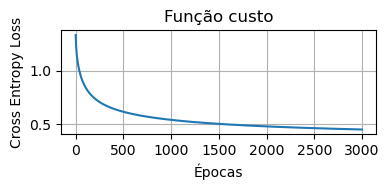

Matriz de confusão:
[[22  0  1  1]
 [ 0 16  7  1]
 [ 3  4 11  0]
 [ 0  0  0 18]]
Acurácia: 0.7976190476190477
Acurácia classe: {0: np.float64(0.9166666666666666), 1: np.float64(0.6666666666666666), 2: np.float64(0.6111111111111112), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 8/10


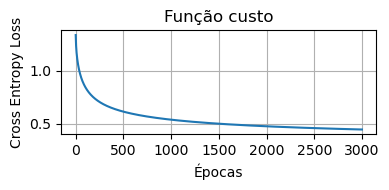

Matriz de confusão:
[[18  0  0  0]
 [ 2 14 11  0]
 [ 2  4 15  0]
 [ 1  0  0 17]]
Acurácia: 0.7619047619047619
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.5185185185185185), 2: np.float64(0.7142857142857143), 3: np.float64(0.9444444444444444)}
------------------------------------------------------------------------------------------------------
k = 9/10


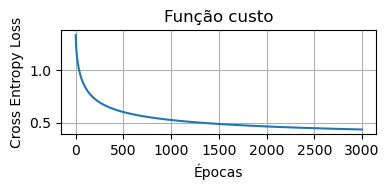

Matriz de confusão:
[[11  0  1  0]
 [ 2  8  9  2]
 [ 0  9 12  1]
 [ 0  0  1 28]]
Acurácia: 0.7023809523809523
Acurácia classe: {0: np.float64(0.9166666666666666), 1: np.float64(0.38095238095238093), 2: np.float64(0.5454545454545454), 3: np.float64(0.9655172413793104)}
------------------------------------------------------------------------------------------------------
k = 10/10


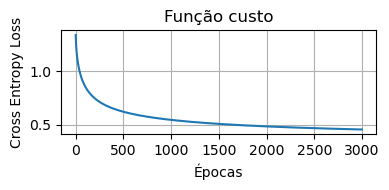

Matriz de confusão:
[[20  1  0  0]
 [ 0 15  3  0]
 [ 0  8 11  0]
 [ 0  0  0 26]]
Acurácia: 0.8571428571428571
Acurácia classe: {0: np.float64(0.9523809523809523), 1: np.float64(0.8333333333333334), 2: np.float64(0.5789473684210527), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------


In [42]:
logit_multinomial_cross_validation.fit(X=X, y=y)

In [43]:
# Na classe CrossValidation, os dados são padronizados se standard=True — utilizando-se as estatísticas apenas dos folds de treino
adg_multi_cross_validation = CrossValidation(modelo=ADG, kfold=10, seed=3, standard=False)

In [44]:
adg_multi_cross_validation.fit(X=X, y=y)

k = 1/10
Matriz de confusão:
[[24  0  0  0]
 [ 0 15  8  1]
 [ 0  3 12  4]
 [ 0  0  0 17]]
Acurácia: 0.8095238095238095
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.625), 2: np.float64(0.631578947368421), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[27  0  0  1]
 [ 0 12  3  1]
 [ 0  6 23  0]
 [ 0  0  0 11]]
Acurácia: 0.8690476190476191
Acurácia classe: {0: np.float64(0.9642857142857143), 1: np.float64(0.75), 2: np.float64(0.7931034482758621), 3: np.float64(1.0)}
------------------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[23  0  0  0]
 [ 0 10  2  1]
 [ 0  8 13  0]
 [ 0  0  0 27]]
Acurácia: 0.8690476190476191
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.7692307692307693), 2: np.float64(0.6190476190476191), 3: np.float64(1.0)}
------------------------------------------------------------------

In [45]:
# Na classe CrossValidation, os dados são padronizados se standard=True — utilizando-se as estatísticas apenas dos folds de treino
naive_bayes_multi_cross_validation = CrossValidation(modelo=NaiveBayesGaussiano, kfold=10, seed=3, standard=False)

In [46]:
naive_bayes_multi_cross_validation.fit(X=X, y=y)

k = 1/10
Matriz de confusão:
[[ 5  4  0 15]
 [ 1  8  6  9]
 [ 0  8  5  6]
 [ 1  0  1 15]]
Acurácia: 0.39285714285714285
Acurácia classe: {0: np.float64(0.20833333333333334), 1: np.float64(0.3333333333333333), 2: np.float64(0.2631578947368421), 3: np.float64(0.8823529411764706)}
------------------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[ 2 12  1 13]
 [ 0  7  0  9]
 [ 1 12 10  6]
 [ 1  0  1  9]]
Acurácia: 0.3333333333333333
Acurácia classe: {0: np.float64(0.07142857142857142), 1: np.float64(0.4375), 2: np.float64(0.3448275862068966), 3: np.float64(0.8181818181818182)}
------------------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[ 1  7  1 14]
 [ 0  7  3  3]
 [ 1  5  9  6]
 [ 1  1  3 22]]
Acurácia: 0.4642857142857143
Acurácia classe: {0: np.float64(0.043478260869565216), 1: np.float64(0.5384615384615384), 2: np.float64(0.42857142857142855), 3: n

## b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe

In [47]:
logit_multinomial_cross_validation.summary()

------------------------------------------------------------
Modelo Regressão Logística Multinomial - Algorítmo GD
------------------------------------------------------------
Acurácia - Média: 0.781 | DP: 0.048
Acurácia por classe:
   - 0 - Média: 0.941 | DP: 0.057
   - 1 - Média: 0.597 | DP: 0.134
   - 2 - Média: 0.628 | DP: 0.051
   - 3 - Média: 0.965 | DP: 0.045
------------------------------------------------------------


In [48]:
adg_multi_cross_validation.summary()

------------------------------------------------------------
Modelo Análise de Discriminante Gaussiano
------------------------------------------------------------
Acurácia - Média: 0.849 | DP: 0.033
Acurácia por classe:
   - 0 - Média: 0.984 | DP: 0.029
   - 1 - Média: 0.738 | DP: 0.099
   - 2 - Média: 0.708 | DP: 0.062
   - 3 - Média: 0.981 | DP: 0.026
------------------------------------------------------------


In [49]:
naive_bayes_multi_cross_validation.summary()

------------------------------------------------------------
Modelo Naive Bayes Gaussiano
------------------------------------------------------------
Acurácia - Média: 0.439 | DP: 0.049
Acurácia por classe:
   - 0 - Média: 0.165 | DP: 0.093
   - 1 - Média: 0.408 | DP: 0.108
   - 2 - Média: 0.346 | DP: 0.094
   - 3 - Média: 0.879 | DP: 0.095
------------------------------------------------------------


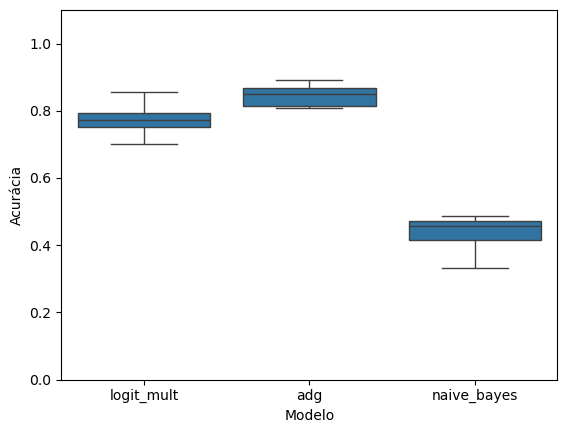

In [50]:
resultados_finais = pd.DataFrame(
    {
        "logit_mult": logit_multinomial_cross_validation.acuracia,
        "adg": adg_multi_cross_validation.acuracia,
        "naive_bayes": naive_bayes_multi_cross_validation.acuracia,
    }
)
resultados_finais = resultados_finais.melt(value_name="Acurácia", var_name="Modelo")
sns.boxplot(data=resultados_finais, y="Acurácia", x="Modelo")
plt.ylim(0, 1.1)
plt.show()

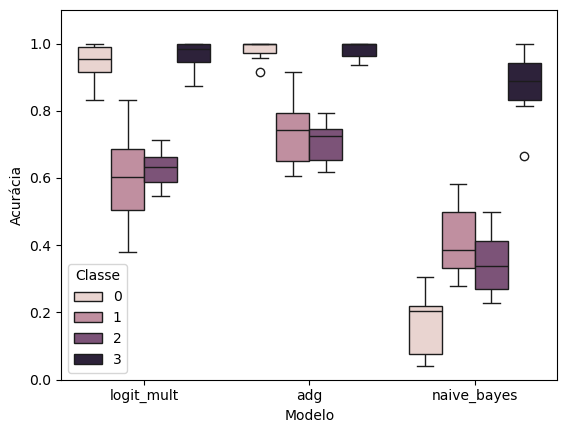

In [51]:
logit_data = pd.DataFrame(logit_multinomial_cross_validation.acuracia_classe).assign(
    Modelo="logit_mult"
)
adg_data = pd.DataFrame(adg_multi_cross_validation.acuracia_classe).assign(Modelo="adg")
naive_bayes_data = pd.DataFrame(
    naive_bayes_multi_cross_validation.acuracia_classe
).assign(Modelo="naive_bayes")
resultados_finais = pd.concat([logit_data, adg_data, naive_bayes_data], axis=0)
resultados_finais = resultados_finais.melt(
    id_vars="Modelo", var_name="Classe", value_name="Acurácia"
)
sns.boxplot(data=resultados_finais, y="Acurácia", x="Modelo", hue="Classe")
plt.ylim(0, 1.1)
plt.show()